<a href="https://colab.research.google.com/github/shreekar2005/Cheminformatics_DC/blob/main/DC2_NN_both_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import io
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import multilabel_confusion_matrix, classification_report

In [74]:
# Load Data using Pandas
y_tr = pd.read_csv('drive/MyDrive/DATASET/tox21_labels_train.csv.gz', index_col=0, compression="gzip")
y_te = pd.read_csv('drive/MyDrive/DATASET/tox21_labels_test.csv.gz', index_col=0, compression="gzip")
x_tr_dense = pd.read_csv('drive/MyDrive/DATASET/tox21_dense_train.csv.gz', index_col=0, compression="gzip").values
x_te_dense = pd.read_csv('drive/MyDrive/DATASET/tox21_dense_test.csv.gz', index_col=0, compression="gzip").values
x_tr_sparse = io.mmread('drive/MyDrive/DATASET/tox21_sparse_train.mtx.gz').tocsc()
x_te_sparse = io.mmread('drive/MyDrive/DATASET/tox21_sparse_test.mtx.gz').tocsc()

# Filter out very sparse features
sparse_col_idx = ((x_tr_sparse > 0).mean(0) > 0.05).A.ravel()
x_tr = np.hstack([x_tr_dense, x_tr_sparse[:, sparse_col_idx].toarray()])
x_te = np.hstack([x_te_dense, x_te_sparse[:, sparse_col_idx].toarray()])

# Standardize features
scaler = StandardScaler()
x_tr = scaler.fit_transform(x_tr)
x_te = scaler.transform(x_te)

# Fill missing values in labels
target_labels = ['NR.AhR', 'NR.AR', 'NR.AR.LBD', 'NR.Aromatase', 'NR.ER', 'NR.ER.LBD',
                 'NR.PPAR.gamma', 'SR.ARE', 'SR.ATAD5', 'SR.HSE', 'SR.MMP', 'SR.p53']
y_tr[target_labels] = y_tr[target_labels].fillna(0).clip(0, 1)
y_te[target_labels] = y_te[target_labels].fillna(0).clip(0, 1)

# Convert to PyTorch tensors on CPU
device = torch.device("cpu")
X_train_torch = torch.tensor(x_tr, dtype=torch.float32)
X_test_torch = torch.tensor(x_te, dtype=torch.float32)
y_train_torch = torch.tensor(y_tr[target_labels].values, dtype=torch.float32)
y_test_torch = torch.tensor(y_te[target_labels].values, dtype=torch.float32)

print("X_train_torch.shape =", X_train_torch.shape)
print("y_train_torch.shape =", y_train_torch.shape)
print("X_test_torch.shape =", X_test_torch.shape)
print("y_test_torch.shape =", y_test_torch.shape)

X_train_torch.shape = torch.Size([12060, 1644])
y_train_torch.shape = torch.Size([12060, 12])
X_test_torch.shape = torch.Size([647, 1644])
y_test_torch.shape = torch.Size([647, 12])


In [75]:
# Data augmentation: Triplet-based averaging
print("before data augmentation : ")
print("X_train_torch.shape =", X_train_torch.shape)
print("y_train_torch.shape =", y_train_torch.shape)
print("X_test_torch.shape =", X_test_torch.shape)
print("y_test_torch.shape =", y_test_torch.shape)

num_new_samples = 8000
print(f"\nadding new {num_new_samples} samples to original {X_train_torch.shape[0]} train samples")
num_samples = X_train_torch.shape[0]
idx1 = torch.randint(0, num_samples, (num_new_samples,))
idx2 = torch.randint(0, num_samples, (num_new_samples,))
idx3 = torch.randint(0, num_samples, (num_new_samples,))
X_new = (X_train_torch[idx1] + X_train_torch[idx2] + X_train_torch[idx3]) / 3.0
y_new = (y_train_torch[idx1].bool() | y_train_torch[idx2].bool() | y_train_torch[idx3].bool()).float()
X_train_torch = torch.cat([X_train_torch, X_new], dim=0)
y_train_torch = torch.cat([y_train_torch, y_new], dim=0)

print("\nafter data augmentation for train samples : ")
print("X_train_torch.shape =", X_train_torch.shape)
print("y_train_torch.shape =", y_train_torch.shape)
print("X_test_torch.shape =", X_test_torch.shape, "...Same as original test data")
print("y_test_torch.shape =", y_test_torch.shape, "  ...Same as original test data")

before data augmentation : 
X_train_torch.shape = torch.Size([12060, 1644])
y_train_torch.shape = torch.Size([12060, 12])
X_test_torch.shape = torch.Size([647, 1644])
y_test_torch.shape = torch.Size([647, 12])

adding new 8000 samples to original 12060 train samples

after data augmentation for train samples : 
X_train_torch.shape = torch.Size([20060, 1644])
y_train_torch.shape = torch.Size([20060, 12])
X_test_torch.shape = torch.Size([647, 1644]) ...Same as original test data
y_test_torch.shape = torch.Size([647, 12])   ...Same as original test data


## Autoencoder

In [63]:
# # Autoencoder definition
# class Autoencoder(nn.Module):
#     def __init__(self, input_dim, latent_dim):
#         super(Autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, 256),
#             nn.ReLU(),
#             nn.Linear(256, latent_dim)
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(latent_dim, 256),
#             nn.ReLU(),
#             nn.Linear(256, input_dim)
#         )

#     def forward(self, x):
#         z = self.encoder(x)
#         out = self.decoder(z)
#         return out

In [64]:
# # Train Autoencoder
# def train_autoencoder(model, data, epochs=20, lr=1e-3):
#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     criterion = nn.MSELoss()
#     model.train()
#     for epoch in range(epochs):
#         optimizer.zero_grad()
#         output = model(data)
#         loss = criterion(output, data)
#         loss.backward()
#         optimizer.step()
#         print(f"Autoencoder Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# input_dim = X_train_torch.shape[1]
# latent_dim = 800
# autoencoder = Autoencoder(input_dim, latent_dim)
# train_autoencoder(autoencoder, X_train_torch, epochs=20)

Autoencoder Epoch 1/20, Loss: 0.7358
Autoencoder Epoch 2/20, Loss: 0.7259
Autoencoder Epoch 3/20, Loss: 0.7064
Autoencoder Epoch 4/20, Loss: 0.6860
Autoencoder Epoch 5/20, Loss: 0.6582
Autoencoder Epoch 6/20, Loss: 0.6337
Autoencoder Epoch 7/20, Loss: 0.6080
Autoencoder Epoch 8/20, Loss: 0.5841
Autoencoder Epoch 9/20, Loss: 0.5613
Autoencoder Epoch 10/20, Loss: 0.5425
Autoencoder Epoch 11/20, Loss: 0.5261
Autoencoder Epoch 12/20, Loss: 0.5109
Autoencoder Epoch 13/20, Loss: 0.4971
Autoencoder Epoch 14/20, Loss: 0.4837
Autoencoder Epoch 15/20, Loss: 0.4703
Autoencoder Epoch 16/20, Loss: 0.4571
Autoencoder Epoch 17/20, Loss: 0.4440
Autoencoder Epoch 18/20, Loss: 0.4316
Autoencoder Epoch 19/20, Loss: 0.4227
Autoencoder Epoch 20/20, Loss: 0.4157


In [65]:
# # Encode features using trained autoencoder
# print("before encoding features : ")
# print("X_train_torch.shape =", X_train_torch.shape)
# print("y_train_torch.shape =", y_train_torch.shape)
# print("X_test_torch.shape =", X_test_torch.shape)
# print("y_test_torch.shape =", y_test_torch.shape)
# with torch.no_grad():
#     X_train_torch = autoencoder.encoder(X_train_torch)
#     X_test_torch = autoencoder.encoder(X_test_torch)
# print("\nafter encoding features : ")
# print("X_train_torch.shape =", X_train_torch.shape)
# print("y_train_torch.shape =", y_train_torch.shape)
# print("X_test_torch.shape =", X_test_torch.shape)
# print("y_test_torch.shape =", y_test_torch.shape,)

before encoding features : 
X_train_torch.shape = torch.Size([20060, 1644])
y_train_torch.shape = torch.Size([20060, 12])
X_test_torch.shape = torch.Size([647, 1644])
y_test_torch.shape = torch.Size([647, 12])

after encoding features : 
X_train_torch.shape = torch.Size([20060, 800])
y_train_torch.shape = torch.Size([20060, 12])
X_test_torch.shape = torch.Size([647, 800])
y_test_torch.shape = torch.Size([647, 12])


## After encoding features

In [76]:
# Create PyTorch DataLoader
def create_dataloader(X, y, batch_size=64, shuffle=True):
    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = create_dataloader(X_train_torch, y_train_torch)
test_loader = create_dataloader(X_test_torch, y_test_torch, batch_size=32, shuffle=False)

In [77]:
# Define Flexible Neural Network Class
class FlexibleNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers=[512, 256], dropout_rate=0.2):
        super(FlexibleNN, self).__init__()
        layers = []
        prev_size = input_size
        for layer_size in hidden_layers:
            layers.append(nn.Linear(prev_size, layer_size))
            layers.append(nn.BatchNorm1d(layer_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = layer_size
        layers.append(nn.Linear(prev_size, output_size))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [86]:
input_size = X_train_torch.shape[1]
output_size = y_train_torch.shape[1]
hidden_layers = [1024, 512, 256, 512, 256]
dropout_rate = 0.1
model = FlexibleNN(input_size, output_size, hidden_layers, dropout_rate).to(device)
print(model)

FlexibleNN(
  (model): Sequential(
    (0): Linear(in_features=1644, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=256, out_features=512, bias=True)
    (13): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.1, inplace=False)
    (16): Linear(in_features=512, out_features=256, bias=True)
    (17): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True,

In [87]:
# Custom Weighted BCE Loss
class EnhancedBCELoss(nn.Module):
    def __init__(self, pos_weight=2.0, fp_weight=1.0):
        super(EnhancedBCELoss, self).__init__()
        self.pos_weight = pos_weight
        self.fp_weight = fp_weight
        self.bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=device))

    def forward(self, outputs, targets):
        # Standard weighted BCE loss
        bce_loss = self.bce(outputs, targets)

        # Calculate probabilities
        probs = torch.sigmoid(outputs)

        # False positive penalty term (focuses on reducing FP)
        fp_mask = (targets == 0)  # Identify negative samples
        fp_loss = (probs * fp_mask).mean()  # Penalize high probabilities for negatives

        # True positive reinforcement term
        tp_mask = (targets == 1)  # Identify positive samples
        tp_reinforcement = ((1 - probs) * tp_mask).mean()  # Reward high probabilities for positives

        # Combined loss
        total_loss = bce_loss + self.fp_weight * fp_loss + tp_reinforcement

        return total_loss

# Usage
criterion = EnhancedBCELoss(pos_weight=10.0, fp_weight=5.0)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [88]:
# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    epoch_losses = []
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), epoch_losses, marker='o', linestyle='-', color='b', label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss vs. Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


Epoch 1/80, Loss: 3.5790
Epoch 2/80, Loss: 3.5330
Epoch 3/80, Loss: 3.5233
Epoch 4/80, Loss: 3.5180
Epoch 5/80, Loss: 3.5140
Epoch 6/80, Loss: 3.5066
Epoch 7/80, Loss: 3.5017
Epoch 8/80, Loss: 3.4995
Epoch 9/80, Loss: 3.4966
Epoch 10/80, Loss: 3.4929
Epoch 11/80, Loss: 3.4922
Epoch 12/80, Loss: 3.4886
Epoch 13/80, Loss: 3.4859
Epoch 14/80, Loss: 3.4853
Epoch 15/80, Loss: 3.4825
Epoch 16/80, Loss: 3.4810
Epoch 17/80, Loss: 3.4789
Epoch 18/80, Loss: 3.4777
Epoch 19/80, Loss: 3.4761
Epoch 20/80, Loss: 3.4761
Epoch 21/80, Loss: 3.4726
Epoch 22/80, Loss: 3.4714
Epoch 23/80, Loss: 3.4694
Epoch 24/80, Loss: 3.4672
Epoch 25/80, Loss: 3.4654
Epoch 26/80, Loss: 3.4638
Epoch 27/80, Loss: 3.4625
Epoch 28/80, Loss: 3.4590
Epoch 29/80, Loss: 3.4597
Epoch 30/80, Loss: 3.4578
Epoch 31/80, Loss: 3.4579
Epoch 32/80, Loss: 3.4544
Epoch 33/80, Loss: 3.4539
Epoch 34/80, Loss: 3.4534
Epoch 35/80, Loss: 3.4524
Epoch 36/80, Loss: 3.4515
Epoch 37/80, Loss: 3.4494
Epoch 38/80, Loss: 3.4502
Epoch 39/80, Loss: 3.

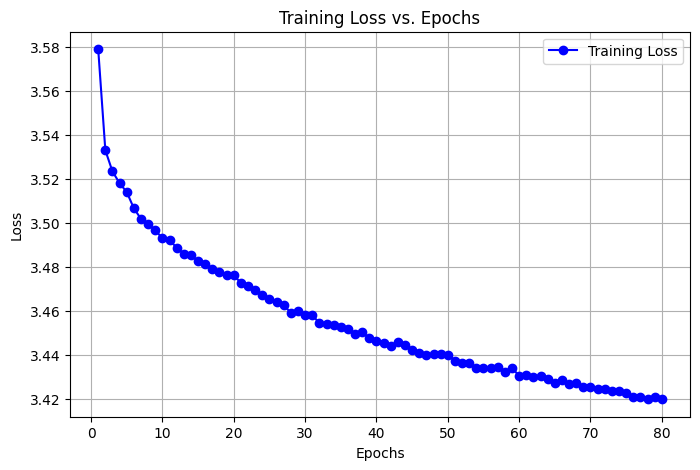

In [89]:
train_model(model, train_loader, criterion, optimizer, epochs=80)


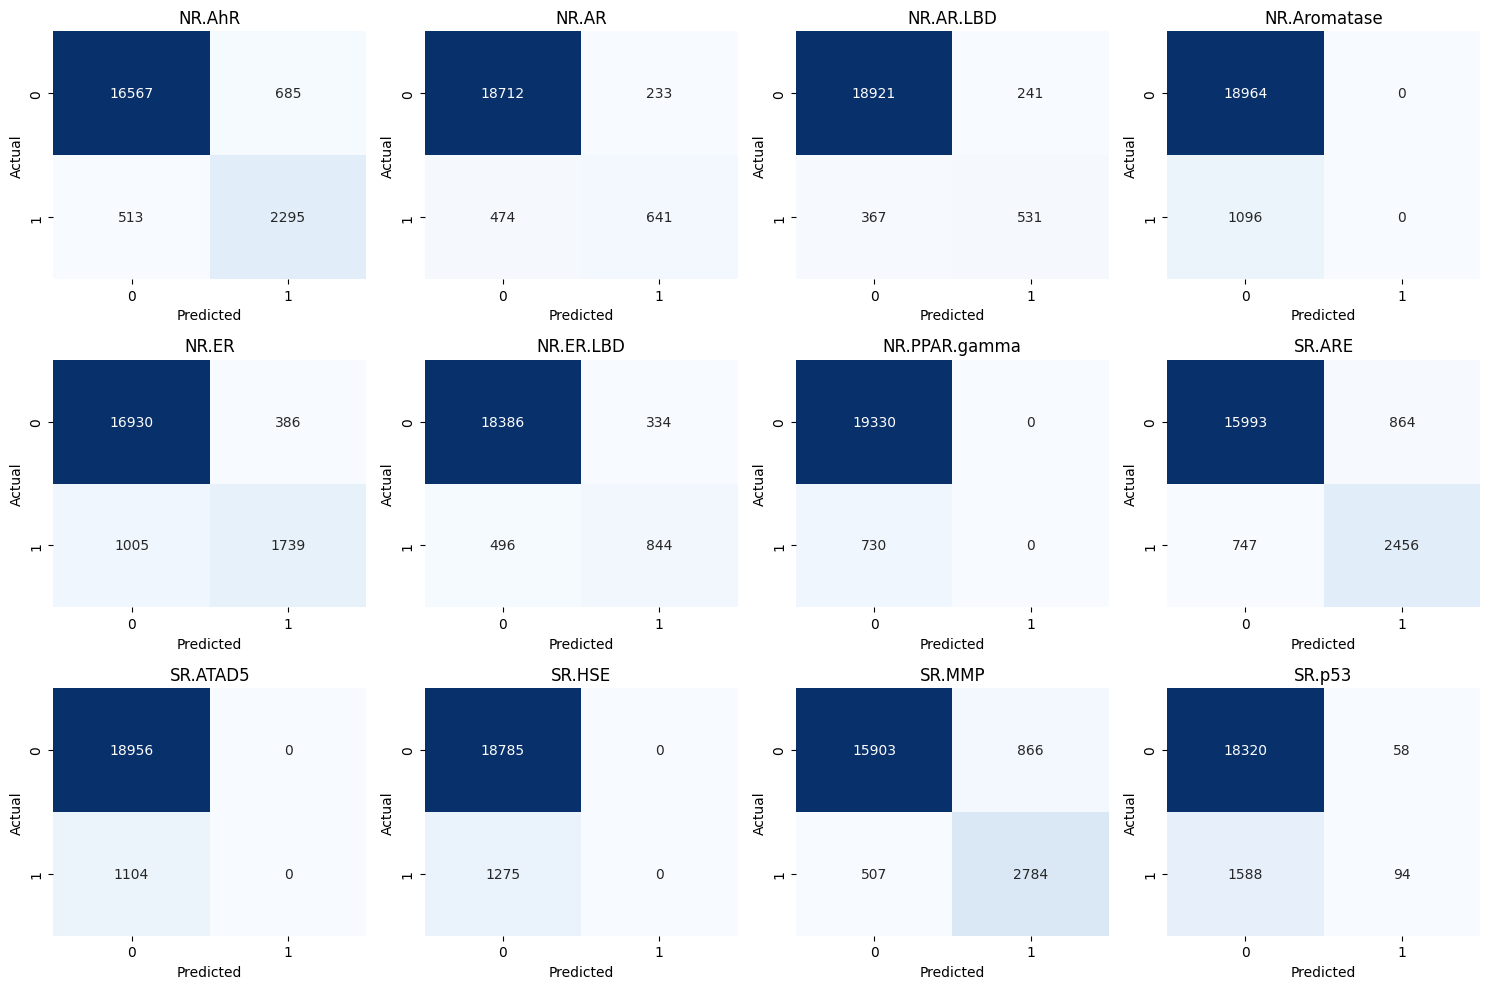

               precision    recall  f1-score   support

       NR.AhR       0.77      0.82      0.79      2808
        NR.AR       0.73      0.57      0.64      1115
    NR.AR.LBD       0.69      0.59      0.64       898
 NR.Aromatase       0.00      0.00      0.00      1096
        NR.ER       0.82      0.63      0.71      2744
    NR.ER.LBD       0.72      0.63      0.67      1340
NR.PPAR.gamma       0.00      0.00      0.00       730
       SR.ARE       0.74      0.77      0.75      3203
     SR.ATAD5       0.00      0.00      0.00      1104
       SR.HSE       0.00      0.00      0.00      1275
       SR.MMP       0.76      0.85      0.80      3291
       SR.p53       0.62      0.06      0.10      1682

    micro avg       0.76      0.53      0.63     21286
    macro avg       0.49      0.41      0.43     21286
 weighted avg       0.60      0.53      0.54     21286
  samples avg       0.27      0.23      0.24     21286



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [90]:
# Evaluation on train
def evaluate_model_train(model, train_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch).cpu().numpy()
            all_preds.append(outputs)
            all_labels.append(y_batch.numpy())
    return np.vstack(all_preds), np.vstack(all_labels)

preds, labels = evaluate_model_train(model, train_loader)
threshold = 0.5
preds = (preds > threshold).astype(int)
conf_matrices = multilabel_confusion_matrix(labels, preds)

fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.flatten()
for i, (ax, label) in enumerate(zip(axes, target_labels)):
    sns.heatmap(conf_matrices[i], annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(label)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()

print(classification_report(labels, preds, target_names=target_labels))

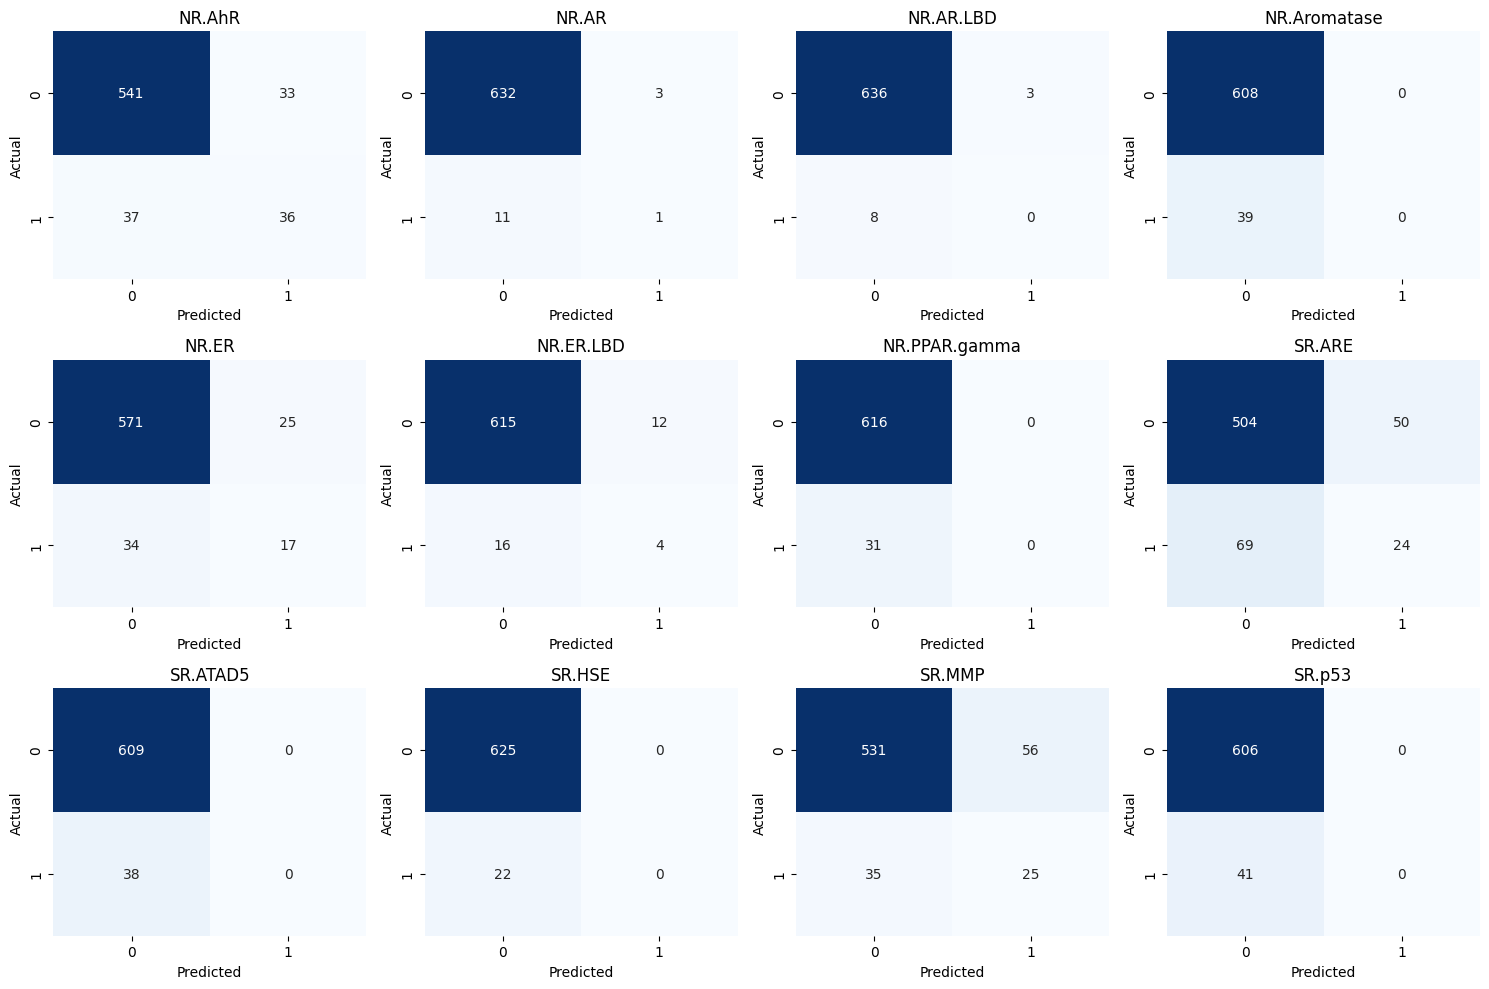

               precision    recall  f1-score   support

       NR.AhR       0.52      0.49      0.51        73
        NR.AR       0.25      0.08      0.12        12
    NR.AR.LBD       0.00      0.00      0.00         8
 NR.Aromatase       0.00      0.00      0.00        39
        NR.ER       0.40      0.33      0.37        51
    NR.ER.LBD       0.25      0.20      0.22        20
NR.PPAR.gamma       0.00      0.00      0.00        31
       SR.ARE       0.32      0.26      0.29        93
     SR.ATAD5       0.00      0.00      0.00        38
       SR.HSE       0.00      0.00      0.00        22
       SR.MMP       0.31      0.42      0.35        60
       SR.p53       0.00      0.00      0.00        41

    micro avg       0.37      0.22      0.28       488
    macro avg       0.17      0.15      0.16       488
 weighted avg       0.24      0.22      0.22       488
  samples avg       0.08      0.07      0.07       488



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [91]:
# Evaluation
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch).cpu().numpy()
            all_preds.append(outputs)
            all_labels.append(y_batch.numpy())
    return np.vstack(all_preds), np.vstack(all_labels)

preds, labels = evaluate_model(model, test_loader)
threshold = 0.5
preds = (preds > threshold).astype(int)
conf_matrices = multilabel_confusion_matrix(labels, preds)

fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.flatten()
for i, (ax, label) in enumerate(zip(axes, target_labels)):
    sns.heatmap(conf_matrices[i], annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(label)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()

print(classification_report(labels, preds, target_names=target_labels))